In [28]:
import pandas as pd
from tqdm import tqdm
import numpy as np

# Import relevant ML libraries
from typing import Optional, Union


import networkx as nx

import torch
from torch import Tensor
import torch.nn as nn
from torch.nn import Embedding, ModuleList, Linear
import torch.nn.functional as F

import torch_geometric
import torch_geometric.nn as pyg_nn
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit
from torch.nn.modules.loss import _Loss

from torch_geometric.nn.conv import LGConv, GATConv, SAGEConv
from torch_geometric.typing import Adj, OptTensor, SparseTensor
from torch_geometric.transforms import KNNGraph

In [3]:
ratings_df = pd.read_csv("./data/full-dataset/ml-explicit/ratings.csv")
movies_df = pd.read_csv("./data/full-dataset/ml-explicit/movies.csv")

full_ratings_df = pd.merge(ratings_df, movies_df[['movieId', 'title']], on='movieId', how='left')
full_ratings_df = full_ratings_df.rename(columns={'title': 'movieName'})
full_ratings_df = full_ratings_df[['userId', 'movieId', 'movieName', 'rating', 'timestamp']]

In [4]:
IDS_TO_MOVIES = dict(zip(movies_df['movieId'], movies_df['title']))
len(IDS_TO_MOVIES.keys())

31271

In [5]:
""" 
  Defining classes to use in the graph. 
  Attempting to build a bipartite graph where the two node types are users and movies. 
"""

movies = []

class Movie:
  """
  Class for a movie, which contains:
    1. ID (unique to Movielens dataset)
    2. Name (the name of the movie)
  """

  def __init__(self, movielens_id):
    self.movielens_id = int(movielens_id)
    self.name = f"movie_{self.movielens_id}"
    self.title = str(IDS_TO_MOVIES[movielens_id])

  def __str__(self):
    return f"Movie {self.movielens_id}: {self.title}"

  def __repr__(self):
    return self.name

In [6]:
class User:
  """
  Class for a user, which contains:
    1. ID (user id on the movielens platform)
    2. Ratings (dictionary of movies rated and their ratings)
  """

  def __init__(self, user_id, ratings):
    self.id = int(user_id)
    self.name = f"user_{user_id}"
    self.ratings = {Movie(key): value for key,value in ratings.items()}

  def __str__(self):
    return f"User: {self.name}"

  def __repr__(self):
    return f"{self.name}"

In [7]:
users = []

grouped_df = full_ratings_df.groupby('userId')

# TODO: remove this eventually???
count = 0

for userID, group_df in tqdm(grouped_df, total=len(grouped_df), desc="Processing Users"):
    ratings_dict = dict(zip(group_df['movieId'], group_df['rating']))
    user = User(userID, ratings_dict)
    users.append(user)
    count += 1
    if count == 50:
        break

Processing Users:   0%|          | 49/200712 [00:01<1:19:28, 42.08it/s]


In [32]:
type(list(users[0].ratings.keys())[0])

__main__.Movie

In [8]:
# we have a list of users, now we just need a list of all the unique movies
movies = [Movie(x) for x in IDS_TO_MOVIES.keys()] 

In [34]:
# ----------------------------------------------------------------------------------------------------------------
# NOTE modification for testing KNNgraphs
# ----------------------------------------------------------------------------------------------------------------

movies = []
for user in users:
    movies.extend([x.name for x in user.ratings.keys()])

MovielensGraph = nx.Graph()
MovielensGraph.add_nodes_from([
    (u.name, {'name':u.name, "node_type" : "user"}) for u in users
])
MovielensGraph.add_nodes_from([
    (m, {'name':m, "node_type" : "movie"}) for m in movies
])

edge_list = []
for user in users:
  for movie in user.ratings.keys():
    edge_list.append((user.name, movie.name))
MovielensGraph.add_edges_from(edge_list)

print('Num nodes:', MovielensGraph.number_of_nodes(), '. Num edges:', MovielensGraph.number_of_edges())

Num nodes: 3728 . Num edges: 7914


In [35]:
nx.get_node_attributes(MovielensGraph, 'name')

{'user_1': 'user_1',
 'user_2': 'user_2',
 'user_3': 'user_3',
 'user_4': 'user_4',
 'user_5': 'user_5',
 'user_6': 'user_6',
 'user_7': 'user_7',
 'user_8': 'user_8',
 'user_9': 'user_9',
 'user_10': 'user_10',
 'user_11': 'user_11',
 'user_12': 'user_12',
 'user_13': 'user_13',
 'user_14': 'user_14',
 'user_15': 'user_15',
 'user_16': 'user_16',
 'user_17': 'user_17',
 'user_18': 'user_18',
 'user_19': 'user_19',
 'user_20': 'user_20',
 'user_21': 'user_21',
 'user_22': 'user_22',
 'user_23': 'user_23',
 'user_24': 'user_24',
 'user_25': 'user_25',
 'user_26': 'user_26',
 'user_27': 'user_27',
 'user_28': 'user_28',
 'user_29': 'user_29',
 'user_30': 'user_30',
 'user_31': 'user_31',
 'user_32': 'user_32',
 'user_33': 'user_33',
 'user_34': 'user_34',
 'user_35': 'user_35',
 'user_36': 'user_36',
 'user_37': 'user_37',
 'user_38': 'user_38',
 'user_39': 'user_39',
 'user_40': 'user_40',
 'user_41': 'user_41',
 'user_42': 'user_42',
 'user_43': 'user_43',
 'user_44': 'user_44',
 'user

In [9]:
# trying something a bit hack-y
MovielensGraph = nx.Graph()
MovielensGraph.add_nodes_from([
    (u.name, {'name':u.name, "node_type" : "user"}) for u in users
])
MovielensGraph.add_nodes_from([
    (m.name, {'name':m.name, "node_type" : "movie"}) for m in movies
])

edge_list = []
for user in users:
  for movie in user.ratings.keys():
    edge_list.append((user.name, movie.name))
MovielensGraph.add_edges_from(edge_list)

print('Num nodes:', MovielensGraph.number_of_nodes(), '. Num edges:', MovielensGraph.number_of_edges())

Num nodes: 31321 . Num edges: 7914


In [ ]:
kcore = 30
MovielensGraph = nx.k_core(MovielensGraph, kcore)
print('Num nodes:', MovielensGraph.number_of_nodes(), '. Num edges:', MovielensGraph.number_of_edges())

In [36]:
import numpy as np

n_nodes, n_edges = MovielensGraph.number_of_nodes(), MovielensGraph.number_of_edges()

# by sorting them we get an ordering playlist1, ..., playlistN, track1, ..., trackN
sorted_nodes = sorted(list(MovielensGraph.nodes()))

# create dictionaries to index to 0 to n_nodes, will be necessary for when we are using tensors
node2id = dict(zip(sorted_nodes, np.arange(n_nodes)))
id2node = dict(zip(np.arange(n_nodes), sorted_nodes))

MovielensGraph = nx.relabel_nodes(MovielensGraph, node2id)

In [37]:
# also keep track of how many playlists, tracks we have
users_idx = [i for i, v in enumerate(node2id.keys()) if "user" in v]
movies_idx = [i for i, v in enumerate(node2id.keys()) if "movie" in v]

n_users = len(users_idx)
n_movies = len(movies_idx)

n_users, n_movies

(50, 3678)

In [38]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_graph(graph_to_plot):

    print("Number of nodes:", graph_to_plot.num_nodes)
    print("Number of edges:", graph_to_plot.edge_index.shape[1])
    print("Edge index:", graph_to_plot.edge_index)
    print("Node positions:", graph_to_plot.pos)

    # Convert edge_index to LongTensor
    edge_index = graph_to_plot.edge_index.long()
    
    # Create a networkx graph from the edge_index
    G = nx.Graph()
    G.add_edges_from(edge_index.t().tolist())

    plt.figure(figsize=(20,20))
    nx.draw(G,
            cmap=plt.get_cmap('coolwarm'),
            node_color="red",
            node_size = 50,
            width = 2,
            edge_color=(0, 0, 0, 0.1))


Number of nodes: 3728
Number of edges: 7914
Edge index: tensor([[3678., 3678., 3678.,  ..., 3723., 3723., 3723.],
        [ 610., 1132., 1342.,  ..., 3106., 3108., 3170.]])
Node positions: tensor([[ 0.2750, -1.1523, -0.2025],
        [ 1.2239,  0.1848, -0.3649],
        [ 0.0863,  1.5746, -0.9419],
        ...,
        [-0.8774, -1.5710, -1.2898],
        [-2.0513, -1.0020, -1.3671],
        [-0.0576,  0.7893, -2.0831]])


/Users/mariavmihu/Documents/MSCI 720/Final_Project/project-env/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


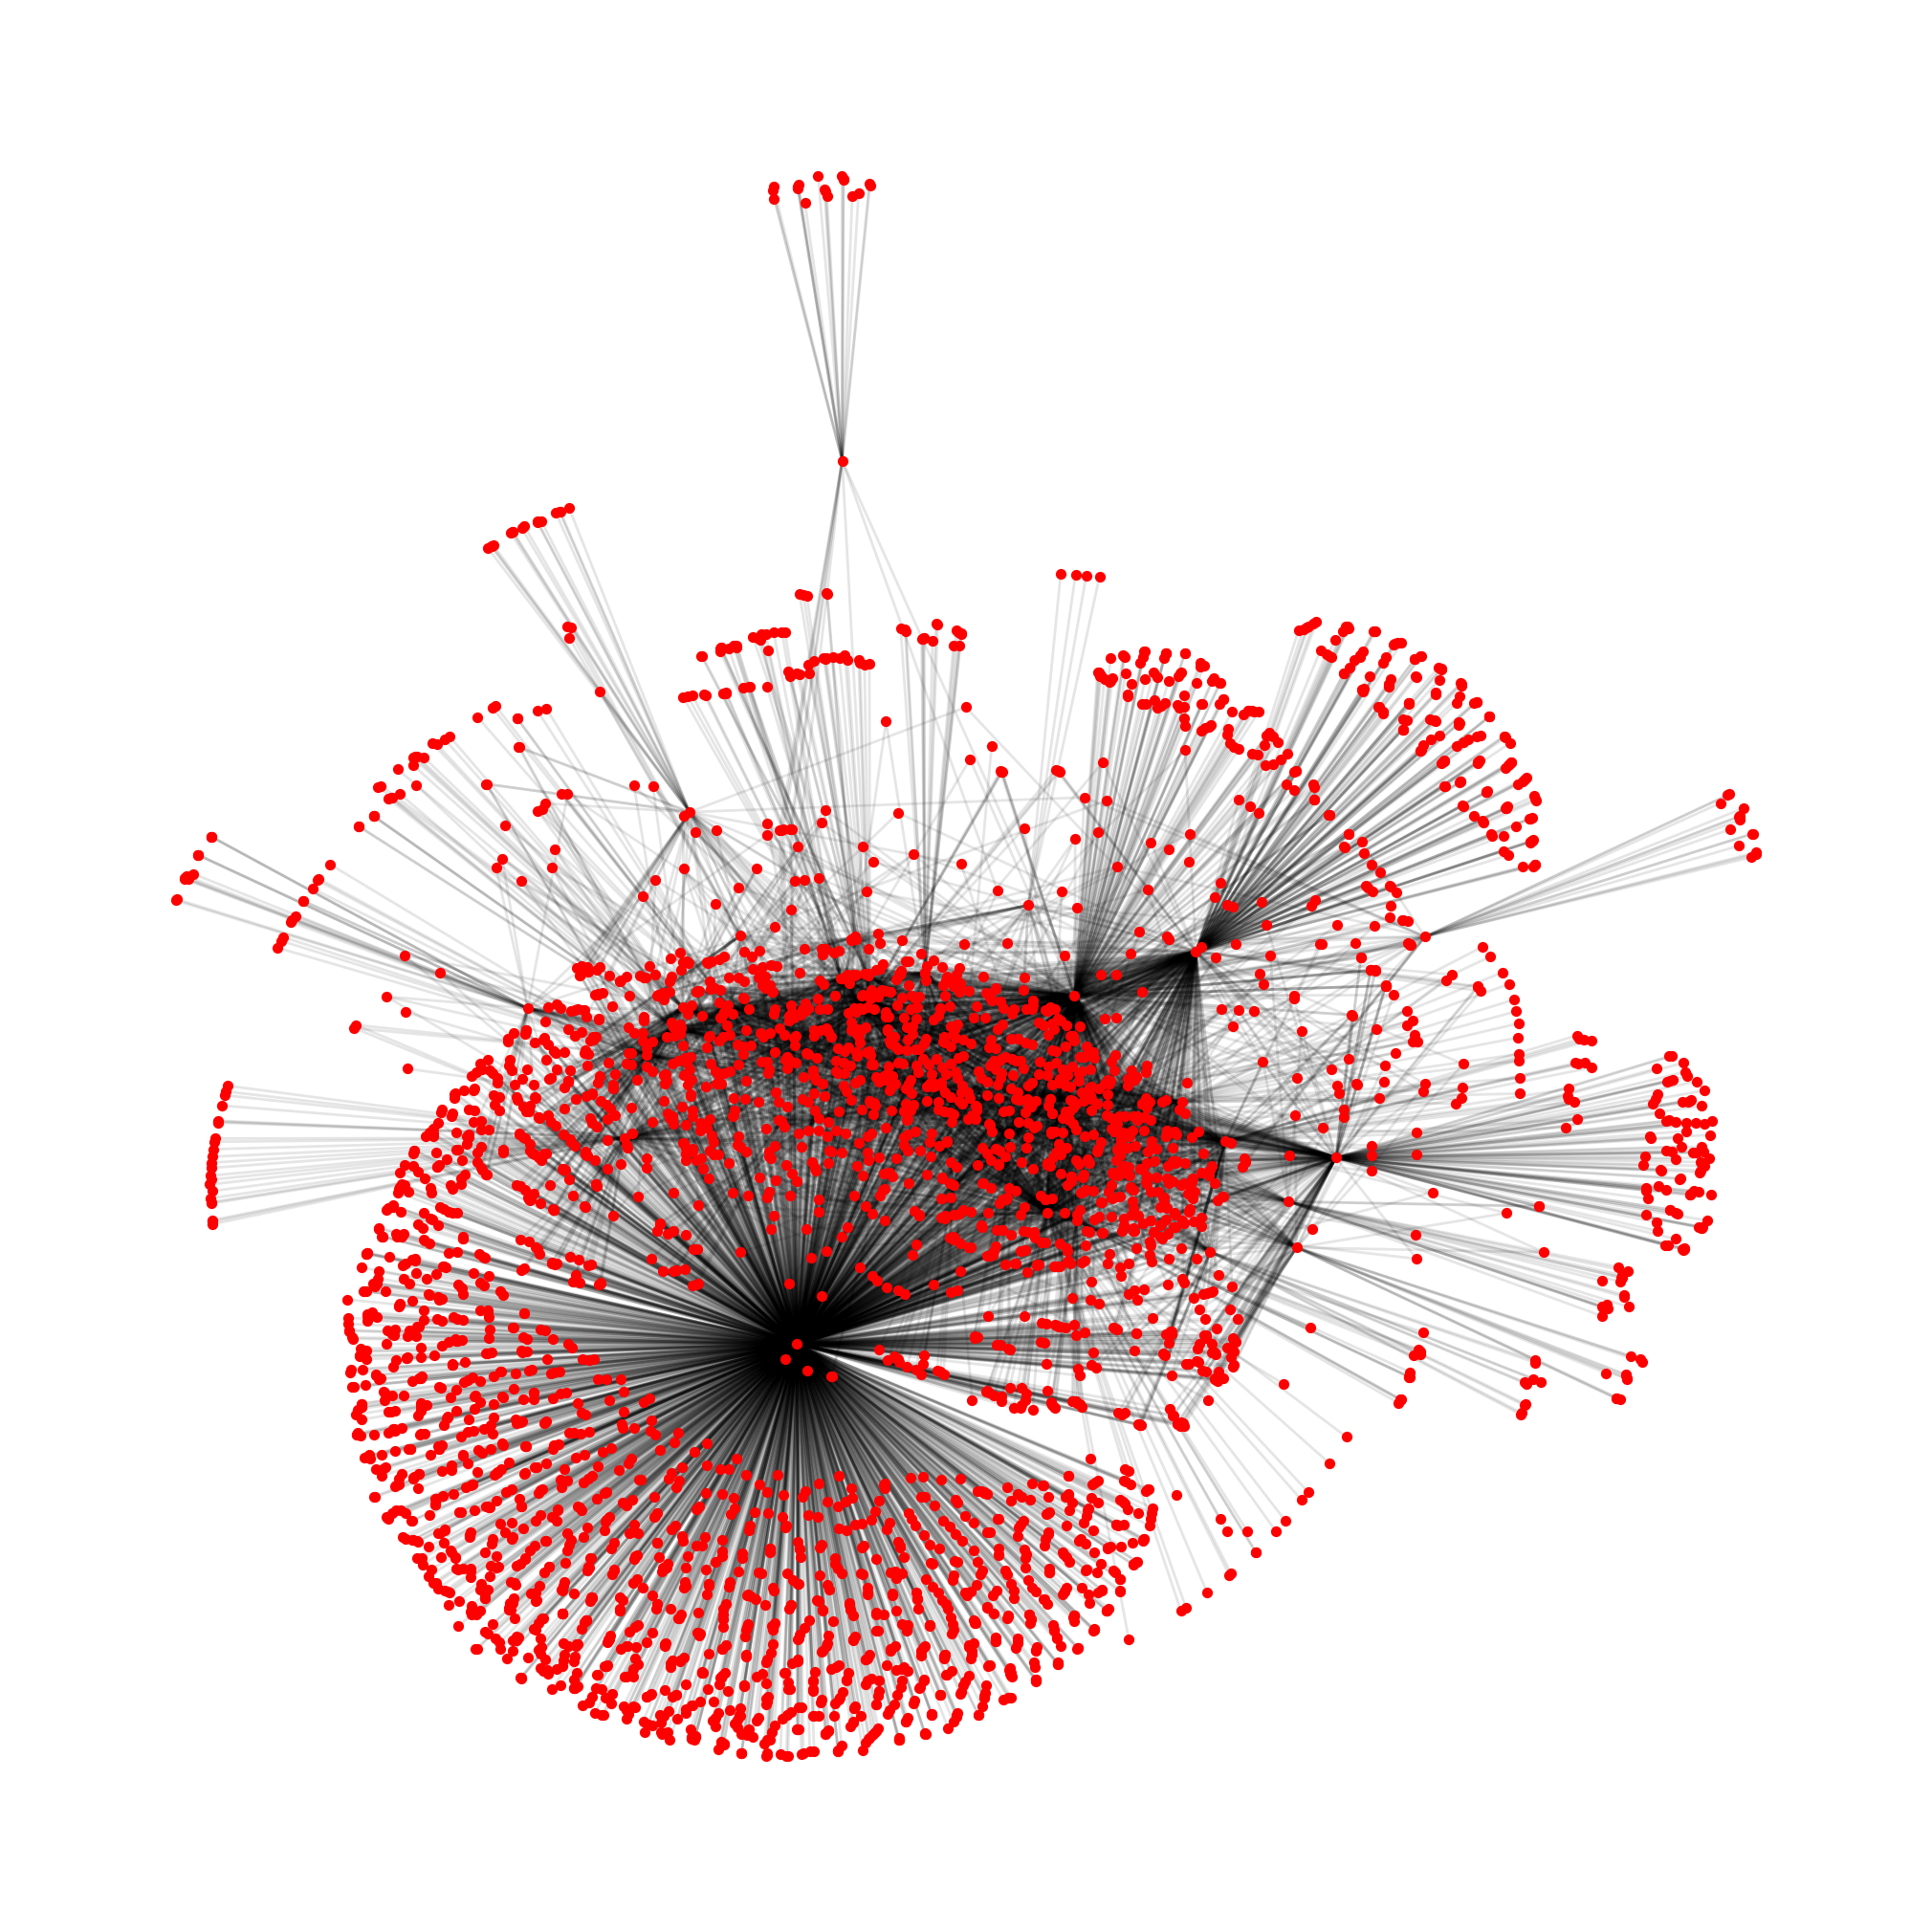

In [39]:
num_nodes = n_users +  n_movies
edge_idx = torch.Tensor(np.array(MovielensGraph.edges()).T)
node_positions = torch.randn(num_nodes, 3)  # Replace 3 with the desired dimensionality
graph_data = Data(edge_index = edge_idx, num_nodes = num_nodes, pos=node_positions)
plot_graph(graph_data)

In [40]:
knn_graph = KNNGraph(k=3)(graph_data)

Number of nodes: 3728
Number of edges: 11184
Edge index: tensor([[2283, 1954, 1127,  ...,   10,  342, 3341],
        [   0,    0,    0,  ..., 3727, 3727, 3727]])
Node positions: tensor([[ 0.2750, -1.1523, -0.2025],
        [ 1.2239,  0.1848, -0.3649],
        [ 0.0863,  1.5746, -0.9419],
        ...,
        [-0.8774, -1.5710, -1.2898],
        [-2.0513, -1.0020, -1.3671],
        [-0.0576,  0.7893, -2.0831]])


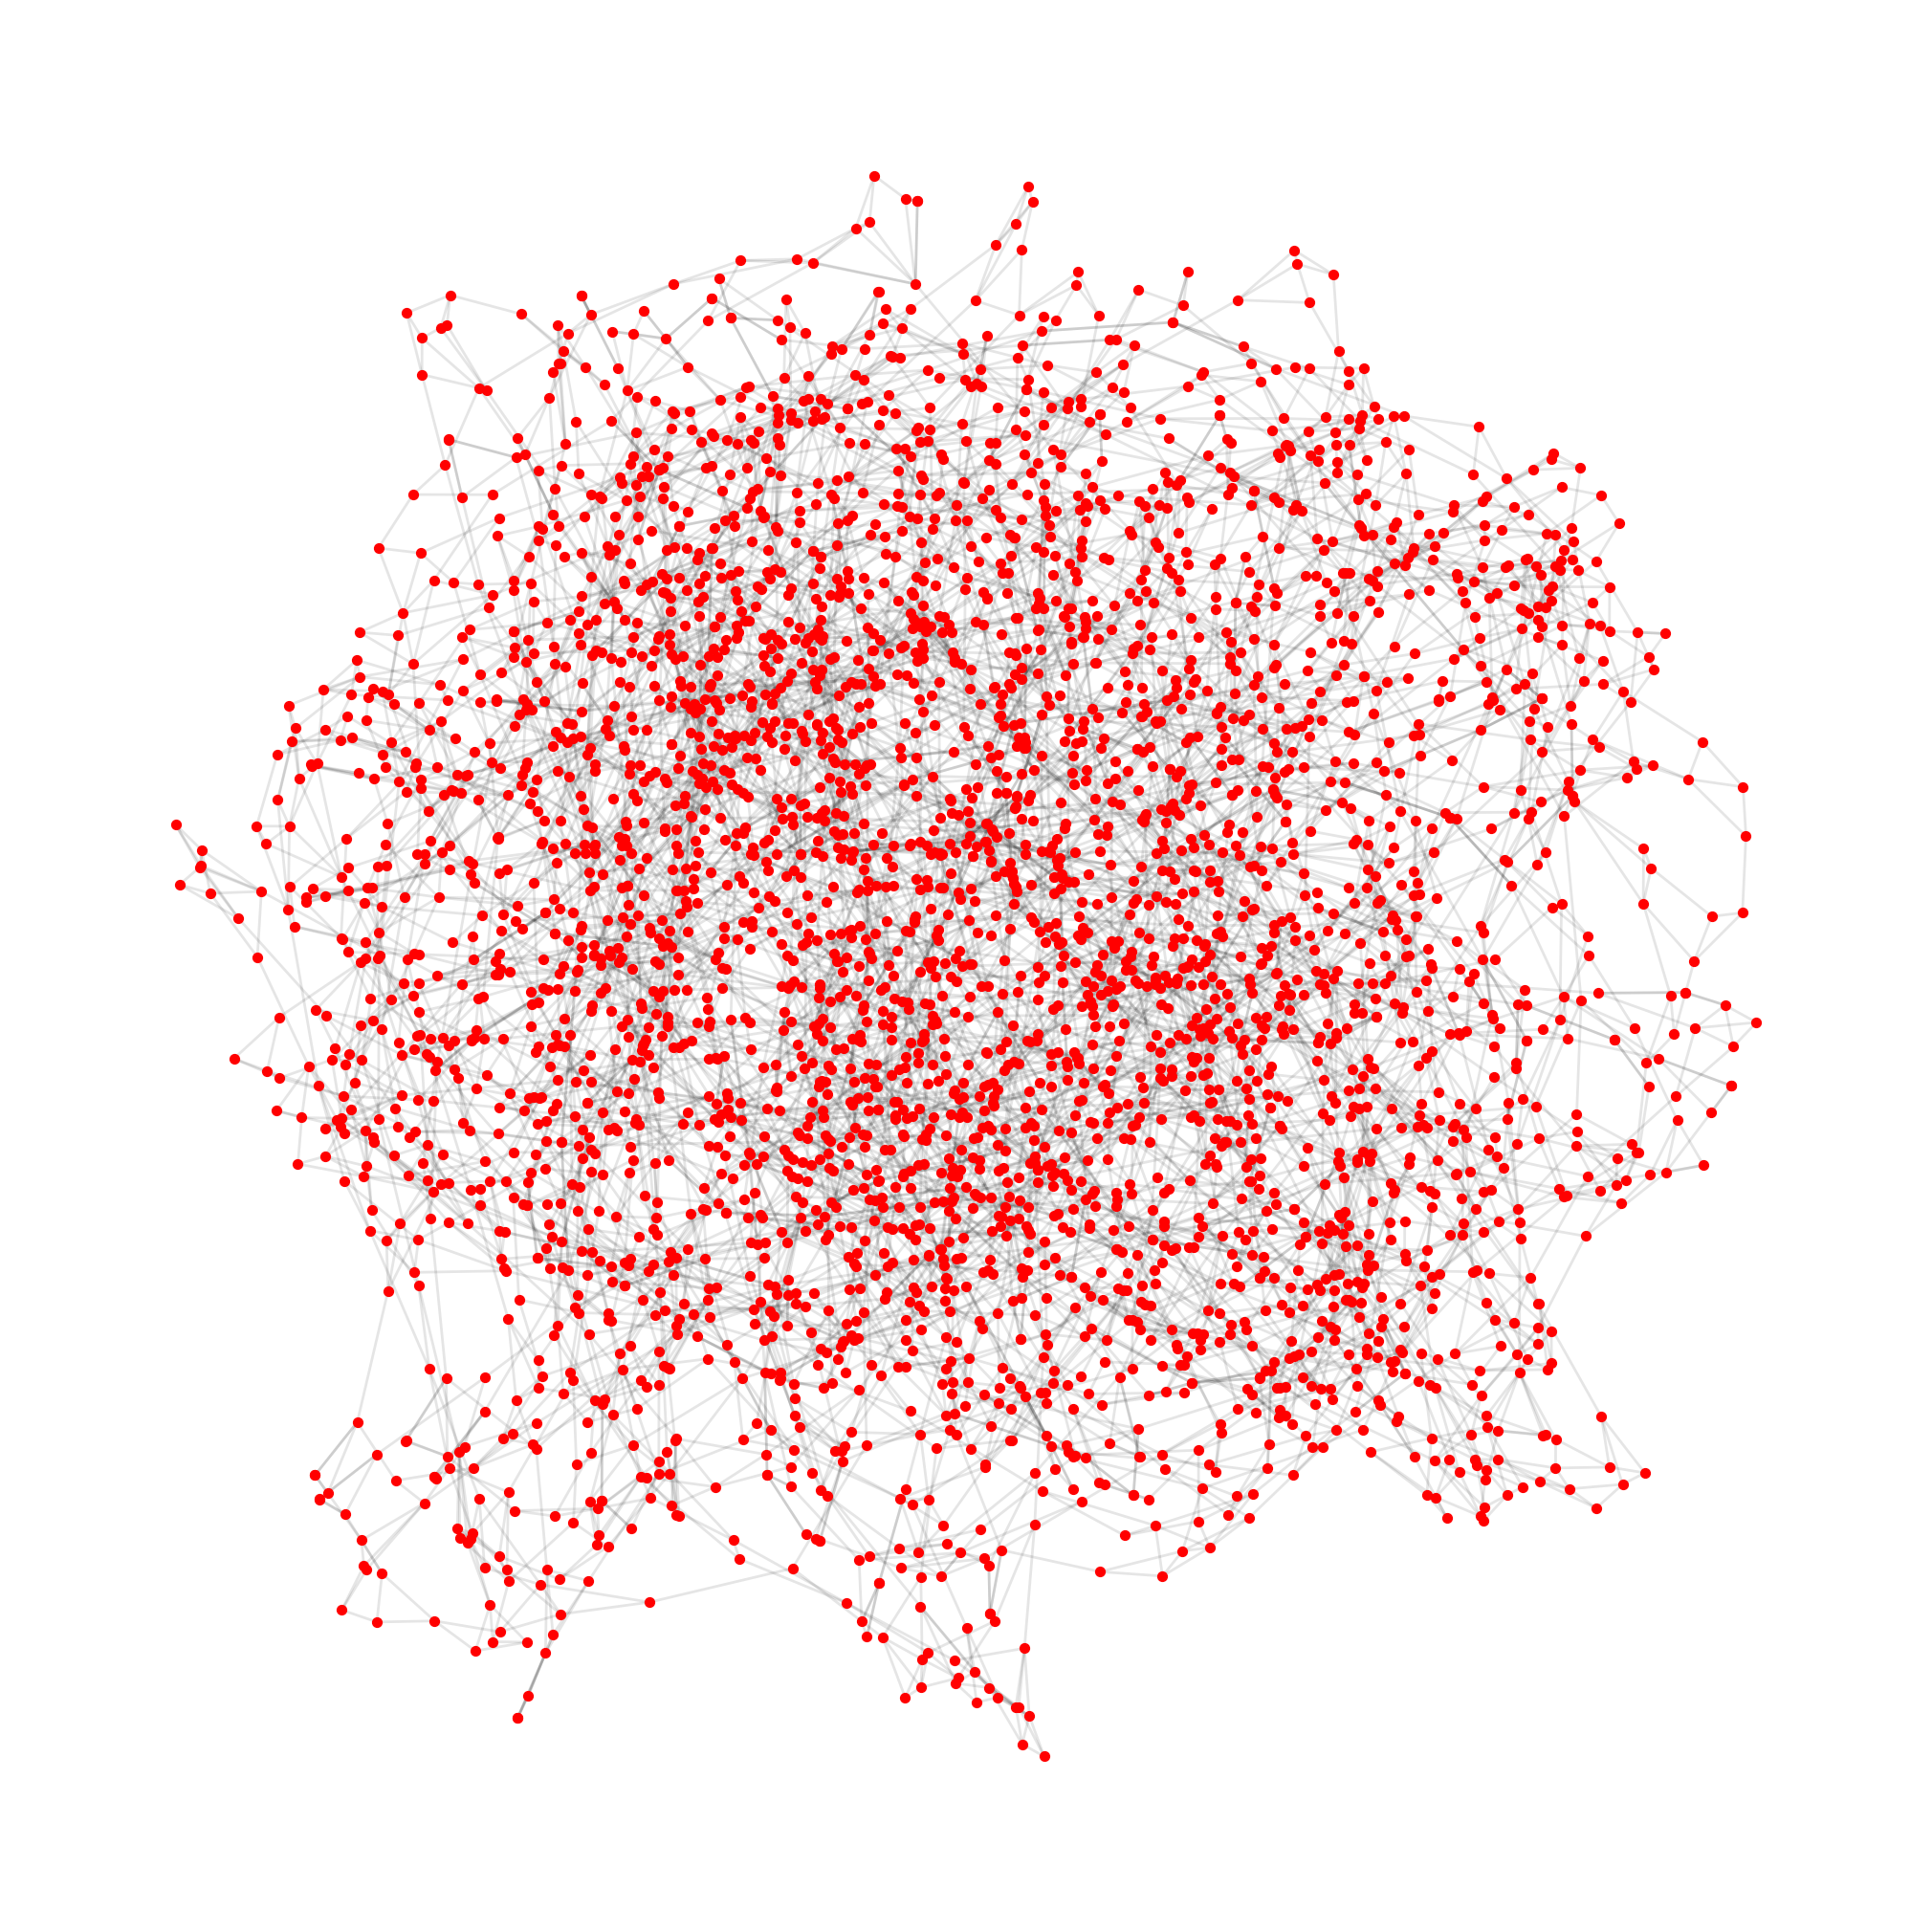

In [43]:
plot_graph(knn_graph)